<a href="https://colab.research.google.com/github/jasminaaa20/EmployeeAttritionAnalysis/blob/main/Employee_Attrition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [ ]:
chatterbox = pd.read_csv('employees.csv')

In [ ]:
chatterbox['Year_of_Birth'] = chatterbox['Year_of_Birth'].apply(lambda x: np.nan if x == "'0000'" else int(x))

In [ ]:
chatterbox.loc[chatterbox['Status'] == 'Active', ['Date_Resigned', 'Inactive_Date']] = '\\N'
chatterbox.loc[chatterbox['Date_Resigned'] == '0000-00-00', 'Date_Resigned'] = '\\N'


count = len(chatterbox[(chatterbox["Status"] == "active") & (chatterbox["Date_Resigned"].notnull() | chatterbox["Inactive_Date"].notnull())])
print(count)

0


In [ ]:
chatterbox.loc[chatterbox['Date_Resigned'] == '0000-00-00', 'Date_Resigned'] = pd.NA
chatterbox.loc[chatterbox['Inactive_Date'] == '0000-00-00', 'Inactive_Date'] = pd.NA

In [ ]:
# Finding the mode, overall and grouped by designation
mode_yob = chatterbox['Year_of_Birth'].mode().values[0]
mode_by_designation = chatterbox.groupby('Designation')['Year_of_Birth'].apply(lambda x: x.mode().values[0] if len(x.mode().values) > 0 else np.nan).reset_index(name='Mode_Year_of_Birth')

# Filling the modes of designations with missing mode with overall mode
mode_by_designation['Mode_Year_of_Birth'].fillna(mode_yob, inplace=True)

# Imputing the missing value by designation mode
dict = mode_by_designation.set_index(mode_by_designation.columns[0]).to_dict()[mode_by_designation.columns[1]]
chatterbox['Year_of_Birth'].fillna(chatterbox['Designation'].map(dict), inplace=True)


In [ ]:
# Assuming the Title column is correct, and correcting inconsistent data
chatterbox.loc[(chatterbox['Title'].isin(['Ms', 'Miss'])), 'Gender'] = 'Female'
chatterbox.loc[(chatterbox['Title'].isin(['Mr'])), 'Gender'] = 'Male'


In [ ]:
# Making a copy for the purpose of training models
chatterbox2 = chatterbox.copy(deep=True)
chatterbox2 = chatterbox2.loc[:,['Employee_No','Title', 'Gender', 'Religion_ID', 'Marital_Status', 'Designation', 'Year_of_Birth']]

# Label encoding the non numeric variables
encoder = LabelEncoder()
chatterbox2['Title'] = encoder.fit_transform(chatterbox2['Title'])
chatterbox2['Designation'] = encoder.fit_transform(chatterbox2['Designation'])
chatterbox2['Gender'] = encoder.fit_transform(chatterbox2['Gender'])
chatterbox2['Marital_Status'] = chatterbox2['Marital_Status'].map({'Married': 0, 'Single': 1})


In [ ]:
# Dividing the dataset into train and test
test = chatterbox2.loc[chatterbox2['Marital_Status'].isna()].drop(['Marital_Status', 'Employee_No'], axis=1)
train = chatterbox2.loc[~chatterbox2['Marital_Status'].isna()]

# Training the Random Forest model
X = train.drop(['Marital_Status', 'Employee_No'], axis=1)
y = train['Marital_Status']

rf = RandomForestClassifier()
rf.fit(X, y)

# Predicting and imputing the missing values
predictions = rf.predict(test)
chatterbox2.loc[chatterbox['Marital_Status'].isna(), 'Marital_Status'] = np.array(predictions)

# Remapping the Marital_Status column
chatterbox2['Marital_Status'] = chatterbox2['Marital_Status'].map({0: 'Married', 1: 'Single'})


In [ ]:
# Imputing the the original dataframe
chatterbox.loc[:,'Marital_Status'] = chatterbox2.loc[:,'Marital_Status']
chatterbox.loc[:,'Year_of_Birth'] = chatterbox2.loc[:,'Year_of_Birth']

# Converting the type of Year_of_Birth
chatterbox['Year_of_Birth'] = chatterbox['Year_of_Birth'].astype('int64')

# Stripping the titles in the names as its in another column
chatterbox['Name'] = chatterbox['Name'].apply(lambda x: x.split(' ', 1)[1] if x.startswith(tuple(chatterbox['Title'].unique())) else x)


In [ ]:
# Exporting
chatterbox.to_csv('/content/employee_preprocess_200238N.csv', index = False)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


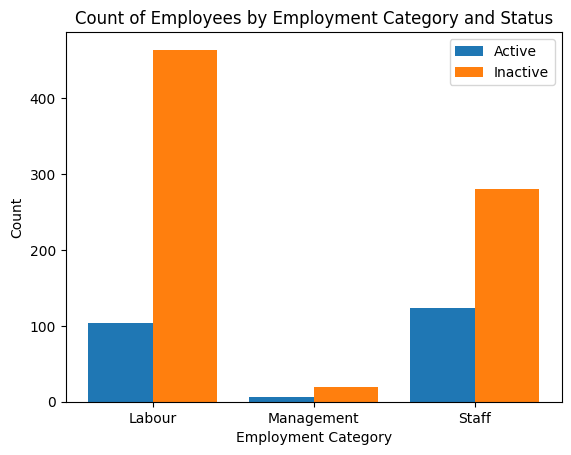

In [ ]:
grouped_df = chatterbox.groupby("Employment_Category")["Status"].value_counts().unstack()

# Get the categories and corresponding index
categories = grouped_df.index
index = np.arange(len(categories))

# Plotting the multiple bar graph
bar_width = 0.4

plt.bar(index - 0.2, grouped_df["Active"], bar_width, label="Active")
plt.bar(index + 0.2, grouped_df["Inactive"], bar_width, label="Inactive")

plt.xlabel("Employment Category")
plt.ylabel("Count")
plt.title("Count of Employees by Employment Category and Status")
plt.xticks(index, categories)
plt.legend()
plt.show()

In [ ]:
salary = pd.read_csv('/content/salary.csv')

In [ ]:
# Find the mode of "Net Salary" for each "Employee_No"
mode_salary = salary.groupby("Employee_No")["Net Salary"].apply(lambda x: x.mode()[0])

# Impute 0 values in "Net Salary" with the mode salary for the corresponding employee
salary["Net Salary"] = salary.apply(lambda row: mode_salary[row["Employee_No"]] if row["Net Salary"] == 0 else row["Net Salary"], axis=1)


In [ ]:
average_salary = salary.groupby("Employee_No")["Net Salary"].mean()

Employee_No
347     34207.534444
348     55814.944444
351     45578.643333
352     33220.818235
354     66650.151765
            ...     
3043    24310.000000
3044    25985.000000
3045    26075.000000
3084    12933.330000
3095        0.000000
Name: Net Salary, Length: 1598, dtype: float64


In [ ]:
combined_df = chatterbox.merge(average_salary, on="Employee_No", how="left")

In [ ]:
print(combined_df)

     Employee_No  Employee_Code               Name Title  Gender  Religion_ID  \
0            347              6  Myrl Bechtelar MD    Mr    Male            1   
1            348             33       Francis Mraz    Mr    Male            1   
2            349             53     Emmet Blick Jr    Mr    Male            1   
3            351             77   Nelson Braun PhD    Ms  Female            4   
4            352             88   Maximillian Hand    Mr    Male            1   
..           ...            ...                ...   ...     ...          ...   
992         2836           5434     Janis Borer Jr    Ms  Female            1   
993         2890           5479      Delphia Haley    Mr    Male            1   
994         2972           5480      Lance Stanton    Mr    Male            1   
995         2973           5481    Chauncey Reilly    Mr    Male            1   
996         3041           5482             Sudath    Mr    Male            1   

    Marital_Status  Designa

In [ ]:
median_salary = combined_df.groupby("Designation")["Net Salary"].transform("median")

# Impute NaN values in "Net Salary" with the median salary for the corresponding "Designation"
combined_df["Net Salary"].fillna(median_salary, inplace=True)


In [ ]:
mean_salary = combined_df["Net Salary"].mean()
combined_df["Net Salary"].fillna(mean_salary, inplace=True)


In [ ]:
nan_count = combined_df["Net Salary"].isnull().sum()
print(nan_count)

0


In [ ]:
print(combined_df)

     Employee_No  Employee_Code               Name Title  Gender  Religion_ID  \
0            347              6  Myrl Bechtelar MD    Mr    Male            1   
1            348             33       Francis Mraz    Mr    Male            1   
2            349             53     Emmet Blick Jr    Mr    Male            1   
3            351             77   Nelson Braun PhD    Ms  Female            4   
4            352             88   Maximillian Hand    Mr    Male            1   
..           ...            ...                ...   ...     ...          ...   
992         2836           5434     Janis Borer Jr    Ms  Female            1   
993         2890           5479      Delphia Haley    Mr    Male            1   
994         2972           5480      Lance Stanton    Mr    Male            1   
995         2973           5481    Chauncey Reilly    Mr    Male            1   
996         3041           5482             Sudath    Mr    Male            1   

    Marital_Status  Designa

In [ ]:
combined_df['Net Salary'] = combined_df['Net Salary'].astype('int64')

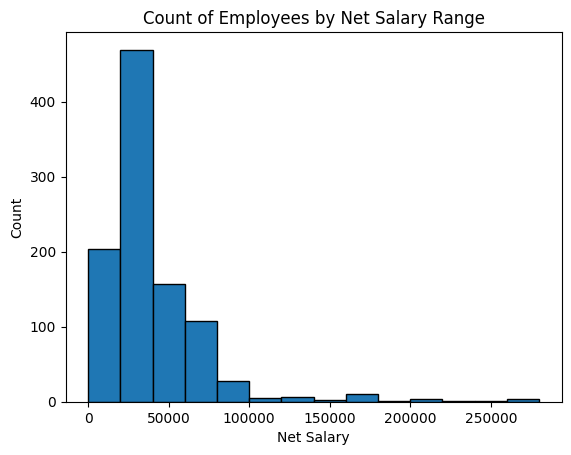

In [ ]:
bins = range(0, 300000, 20000)

# Plot the histogram
plt.hist(combined_df["Net Salary"], bins=bins, edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel("Net Salary")
plt.ylabel("Count")

# Set the title of the graph
plt.title("Count of Employees by Net Salary Range")

# Show the graph
plt.show()


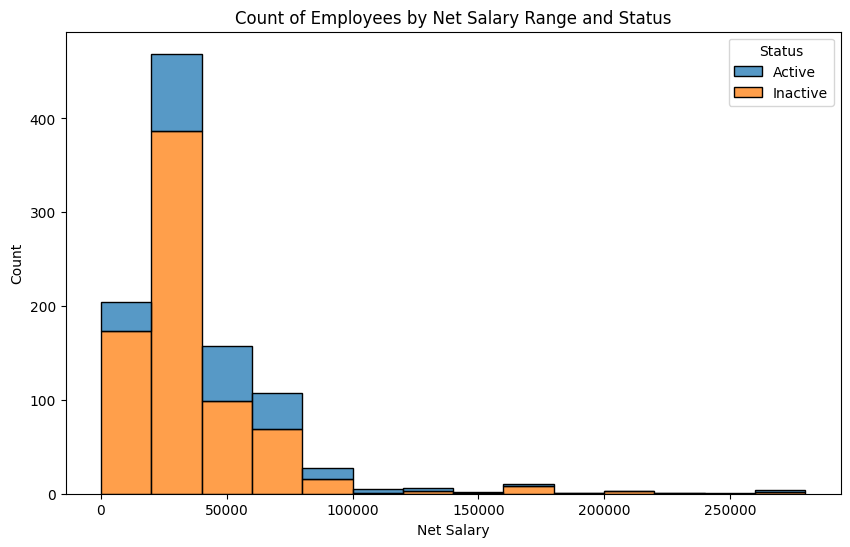

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create bins for salary ranges with a step of 20,000
bins = range(0, 300000, 20000)

# Plot the grouped histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="Net Salary", hue="Status", bins=bins, multiple="stack", edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel("Net Salary")
plt.ylabel("Count")

# Set the title of the graph
plt.title("Count of Employees by Net Salary Range and Status")

# Show the graph
plt.show()


In [ ]:
combined_df['Date_Joined'] = pd.to_datetime(combined_df['Date_Joined'], format='%m/%d/%Y')

# Find the earliest and latest dates
earliest_date = combined_df['Date_Joined'].min()
latest_date = combined_df['Date_Joined'].max()

# Print the earliest and latest dates
print("Earliest date:", earliest_date)
print("Latest date:", latest_date)

Earliest date: 1988-01-27 00:00:00
Latest date: 2022-12-20 00:00:00


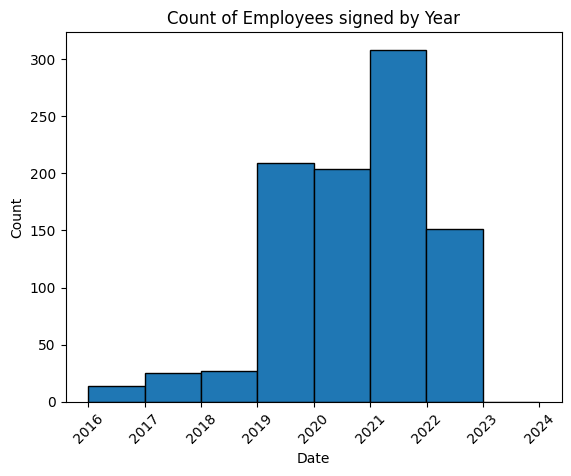

In [ ]:
# Convert the "Date_Joined" field to a datetime type if it's not already
combined_df['Date_Joined'] = pd.to_datetime(combined_df['Date_Joined'])

# Set the desired date range
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-12-31')

# Filter the DataFrame based on the date range
filtered_df = combined_df[(combined_df['Date_Joined'] >= start_date) & (combined_df['Date_Joined'] <= end_date)]

# Create a histogram with steps of one year
plt.hist(filtered_df['Date_Joined'], bins=pd.date_range(start_date, end_date, freq='Y'), edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Count')

# Set the title of the graph
plt.title('Count of Employees signed by Year')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the graph
plt.show()


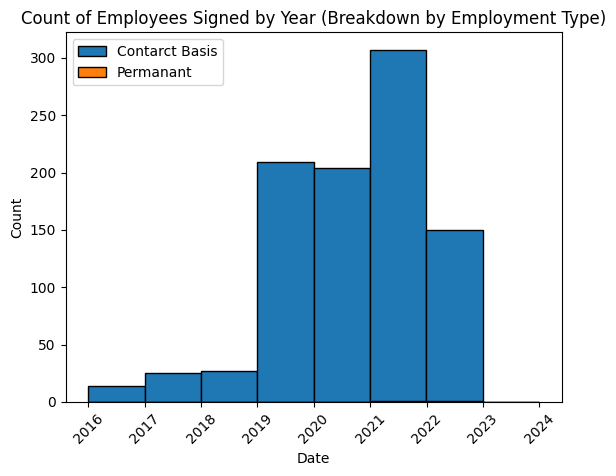

In [ ]:
# Convert the "Date_Joined" field to a datetime type if it's not already
combined_df['Date_Joined'] = pd.to_datetime(combined_df['Date_Joined'])

# Set the desired date range
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-12-31')

# Filter the DataFrame based on the date range
filtered_df = combined_df[(combined_df['Date_Joined'] >= start_date) & (combined_df['Date_Joined'] <= end_date)]

# Get unique values of the "Employment_Type" field
employment_types = filtered_df['Employment_Type'].unique()

# Create separate histograms for each employment type
for employment_type in employment_types:
    # Filter the DataFrame for the current employment type
    subset_df = filtered_df[filtered_df['Employment_Type'] == employment_type]

    # Create a histogram with steps of one year for the current employment type
    plt.hist(subset_df['Date_Joined'], bins=pd.date_range(start_date, end_date, freq='Y'), edgecolor='black', label=employment_type)

# Set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Count')

# Set the title of the graph
plt.title('Count of Employees Signed by Year (Breakdown by Employment Type)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the graph
plt.show()


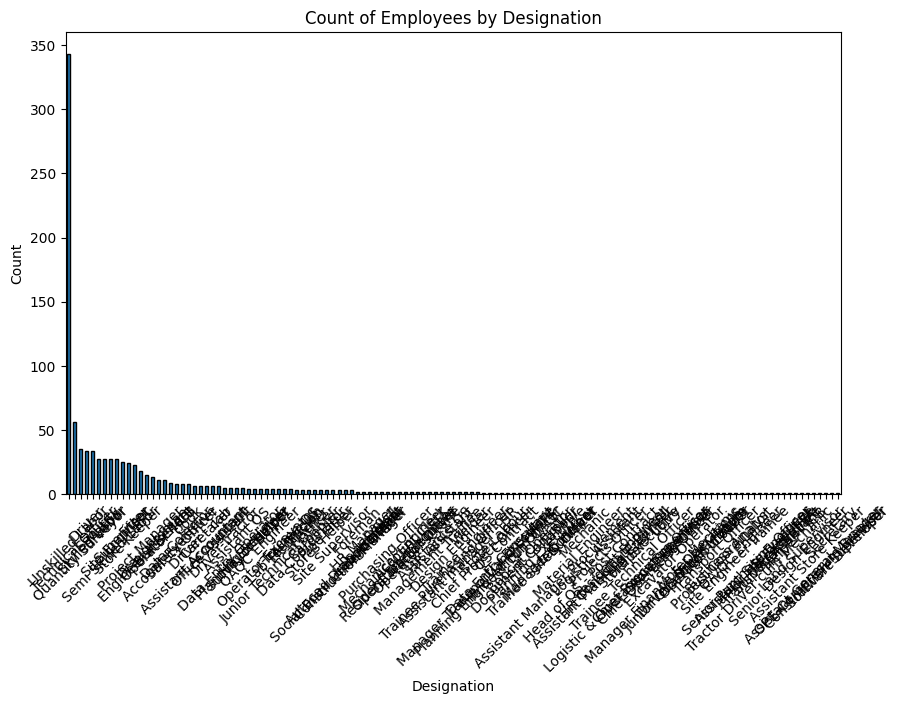

In [ ]:
designation_counts = combined_df['Designation'].value_counts()

# Create a bar plot of the designation counts
plt.figure(figsize=(10, 6))
designation_counts.plot(kind='bar', edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel('Designation')
plt.ylabel('Count')

# Set the title of the graph
plt.title('Count of Employees by Designation')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the graph
plt.show()

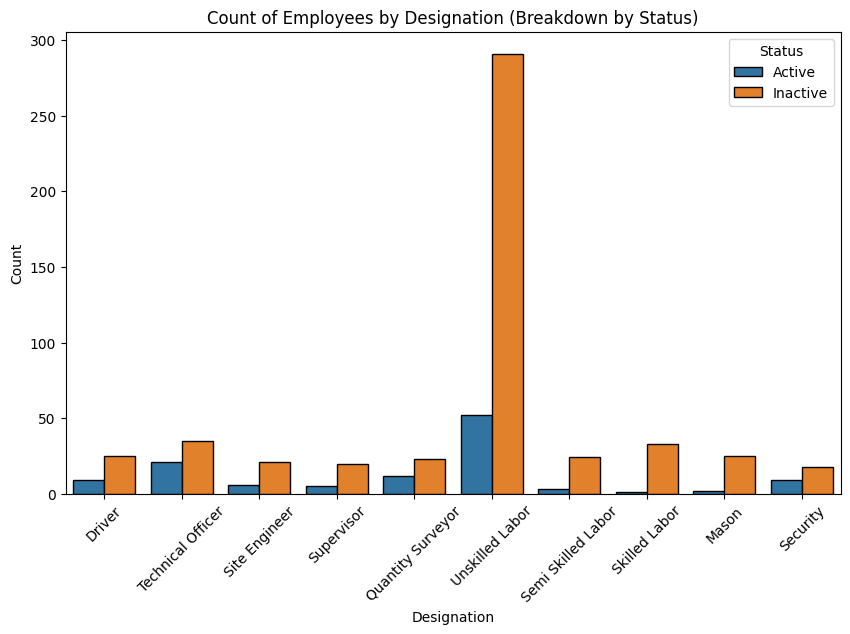

In [ ]:
# Group the DataFrame by "Designation" and "Status" and calculate the count
designation_status_counts = combined_df.groupby(['Designation', 'Status']).size().unstack()

# Select only the top 10 designations with the highest counts
top_10_designations = designation_status_counts.sum(axis=1).nlargest(10).index

# Filter the DataFrame for the top 10 designations
filtered_df = combined_df[combined_df['Designation'].isin(top_10_designations)]

# Create a stacked bar plot of the top 10 designations by status
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, x='Designation', hue='Status', edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel('Designation')
plt.ylabel('Count')

# Set the title of the graph
plt.title('Count of Employees by Designation (Breakdown by Status)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend
plt.legend(title='Status')

# Show the graph
plt.show()


In [ ]:
# Create a new DataFrame with "Employee_No" and "Area" columns from the "Salary" DataFrame
employee_area_df = salary[['Employee_No', 'Area']].drop_duplicates()

# Merge the new DataFrame with the "chatterbox" DataFrame based on "Employee_No"
combined_df = pd.merge(chatterbox, employee_area_df, on='Employee_No', how='left')

# Drop any duplicates based on the "Employee_No" column in the "chatterbox" DataFrame
combined_df = combined_df.drop_duplicates(subset='Employee_No')

# Print the combined DataFrame
print(combined_df)


      Employee_No  Employee_Code               Name Title  Gender  \
0             347              6  Myrl Bechtelar MD    Mr    Male   
1             348             33       Francis Mraz    Mr    Male   
4             349             53     Emmet Blick Jr    Mr    Male   
5             351             77   Nelson Braun PhD    Ms  Female   
6             352             88   Maximillian Hand    Mr    Male   
...           ...            ...                ...   ...     ...   
1077         2836           5434     Janis Borer Jr    Ms  Female   
1078         2890           5479      Delphia Haley    Mr    Male   
1079         2972           5480      Lance Stanton    Mr    Male   
1080         2973           5481    Chauncey Reilly    Mr    Male   
1081         3041           5482             Sudath    Mr    Male   

      Religion_ID Marital_Status  Designation_ID Date_Joined Date_Resigned  \
0               1        Married              24   12/8/1993            \N   
1              

In [ ]:
combined_df.dropna(subset=['Area'], inplace=True)

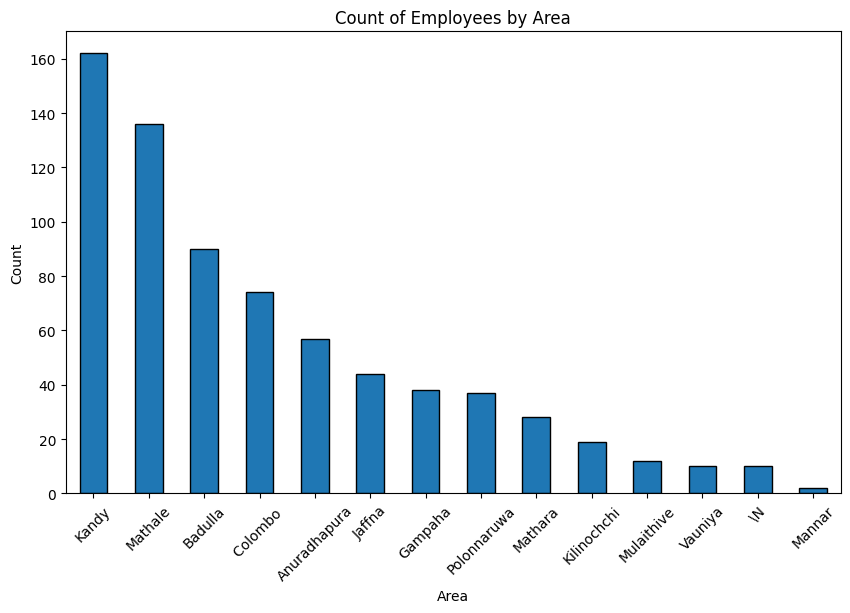

In [ ]:
area_counts = combined_df['Area'].value_counts()

# Create a bar plot of the area counts
plt.figure(figsize=(10, 6))
area_counts.plot(kind='bar', edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel('Area')
plt.ylabel('Count')

# Set the title of the graph
plt.title('Count of Employees by Area')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the graph
plt.show()

<Figure size 1000x600 with 0 Axes>

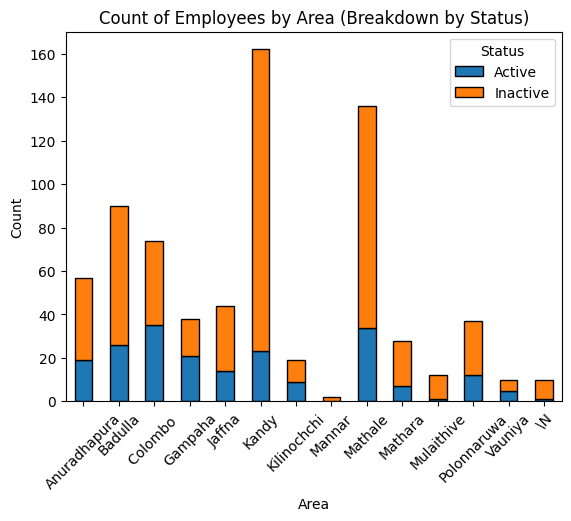

In [ ]:
area_status_counts = combined_df.groupby(['Area', 'Status']).size().unstack()

# Create a stacked bar plot of the area counts by status
plt.figure(figsize=(10, 6))
area_status_counts.plot(kind='bar', stacked=True, edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel('Area')
plt.ylabel('Count')

# Set the title of the graph
plt.title('Count of Employees by Area (Breakdown by Status)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend
plt.legend(title='Status')

# Show the graph
plt.show()
